In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Lambda, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
# Set hyperparameters
batch_size = 64
learning_rate = 0.0005
epochs = 100
num_classes = 10

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Add channel dimension and normalize
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0    # Add channel dimension and normalize
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define modified activation function LPAF
def lpaf(x):
    """Modified LPAF with scaling and bounding."""
    alpha = 0.1  # Scaling factor
    return tf.math.tanh(alpha * x * tf.math.log(1 + x**2))

# Define a custom callback to measure training time per epoch
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)
        print(f"Epoch {epoch+1} completed in {self.times[-1]:.2f} seconds")

# Function to add activation layers
def add_activation(model, activation_function):
    if activation_function == 'relu':
        model.add(Activation('relu'))
    else:
        model.add(Lambda(activation_function))

# Function to build CNN model with specified activation function
def build_model(activation_function):
    weight_decay = 1e-4  # L2 regularization factor
    model = Sequential()
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(Dropout(0.2))
    # Second Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Third Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(Dropout(0.3))
    # Fourth Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training with ReLU activation
print("Training with ReLU activation")
model_relu = build_model('relu')
optimizer = Adam(learning_rate=learning_rate)
model_relu.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
time_callback = TimeHistory()
history_relu = model_relu.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(x_test, y_test),
                              shuffle=True,
                              callbacks=[time_callback, early_stopping])

# Save the ReLU model
model_relu.save('model_relu_mnist.h5')

# Training with LPAF activation
print("\nTraining with LPAF activation")
def lpaf_activation(x):
    return lpaf(x)

model_lpaf = build_model(lpaf_activation)
optimizer = Adam(learning_rate=learning_rate)
model_lpaf.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
time_callback_lpaf = TimeHistory()
history_lpaf = model_lpaf.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(x_test, y_test),
                              shuffle=True,
                              callbacks=[time_callback_lpaf, early_stopping])

# Save the LPAF model
model_lpaf.save('model_lpaf_mnist.h5')

# Compare results
print("\nComparing Results:")
print("Final Training Accuracy with ReLU:", history_relu.history['accuracy'][-1])
print("Final Validation Accuracy with ReLU:", history_relu.history['val_accuracy'][-1])
print("Final Training Accuracy with LPAF:", history_lpaf.history['accuracy'][-1])
print("Final Validation Accuracy with LPAF:", history_lpaf.history['val_accuracy'][-1])



Training with ReLU activation


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9013 - loss: 0.4143Epoch 1 completed in 24.71 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.9013 - loss: 0.4141 - val_accuracy: 0.9862 - val_loss: 0.1396
Epoch 2/100
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9815 - loss: 0.1524Epoch 2 completed in 26.21 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.9815 - loss: 0.1524 - val_accuracy: 0.9847 - val_loss: 0.1267
Epoch 3/100
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9853 - loss: 0.1216Epoch 3 completed in 6.04 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9853 - loss: 0.1216 - val_accuracy: 0.9896 - val_loss: 0.0966
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9884 - loss: 0.1015Epoch 4 completed in 6.01 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9884 - loss: 0.1015 - val_accuracy: 0.9891 - val_loss: 0.0913
Epoch 5/100
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6m


Training with LPAF activation
Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9008 - loss: 0.5828Epoch 1 completed in 21.52 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.9008 - loss: 0.5825 - val_accuracy: 0.9832 - val_loss: 0.1219
Epoch 2/100
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9851 - loss: 0.1203Epoch 2 completed in 6.46 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9851 - loss: 0.1203 - val_accuracy: 0.9910 - val_loss: 0.0874
Epoch 3/100
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9874 - loss: 0.0963Epoch 3 completed in 10.57 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9874 - loss: 0.0963 - val_accuracy: 0.9898 - val_loss: 0.0755
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9882 - loss: 0.0860Epoch 4 completed in 6.83 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9882 - loss: 0.0860 - val_accuracy: 0.9902 - val_loss: 0.0740
Epoch 5/100
932


Comparing Results:
Final Training Accuracy with ReLU: 0.9948166608810425
Final Validation Accuracy with ReLU: 0.9919000267982483
Final Training Accuracy with LPAF: 0.9912166595458984
Final Validation Accuracy with LPAF: 0.9901000261306763



Visualizing feature maps for ReLU model
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


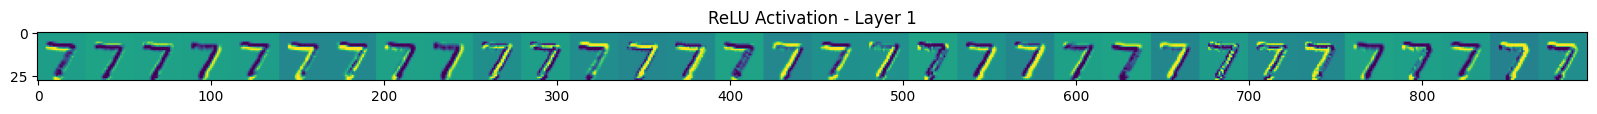

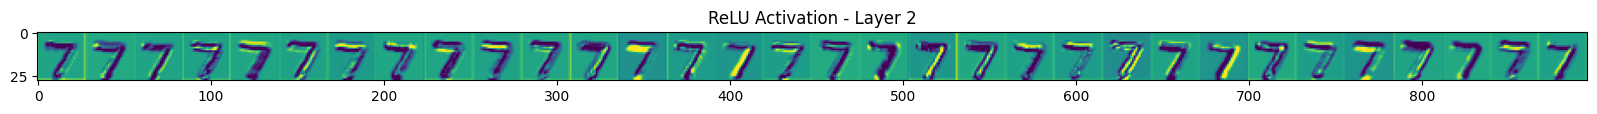

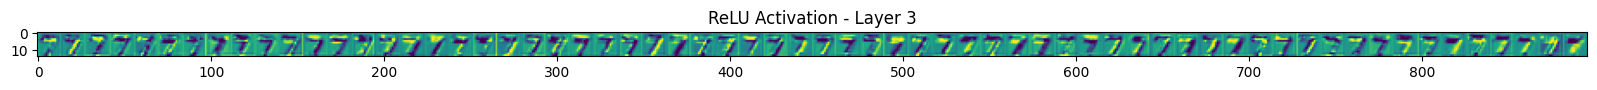

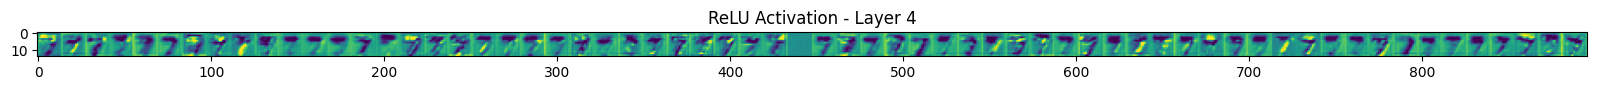


Visualizing feature maps for LPAF model
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


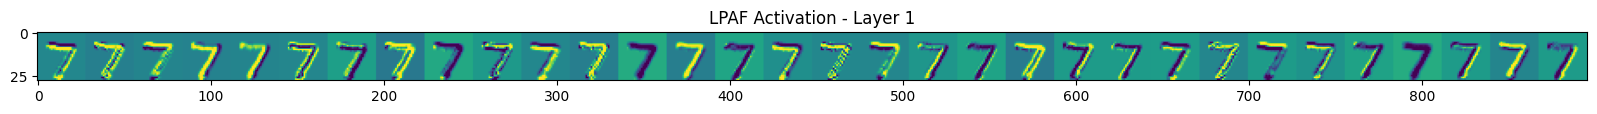

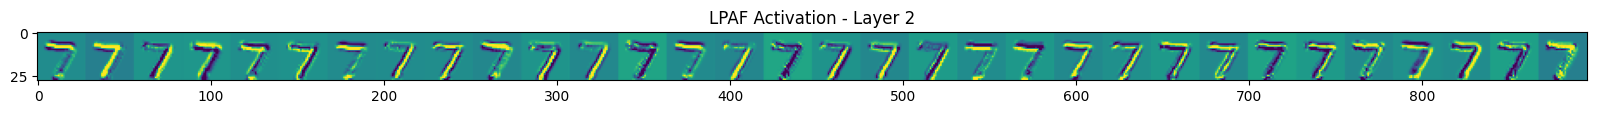

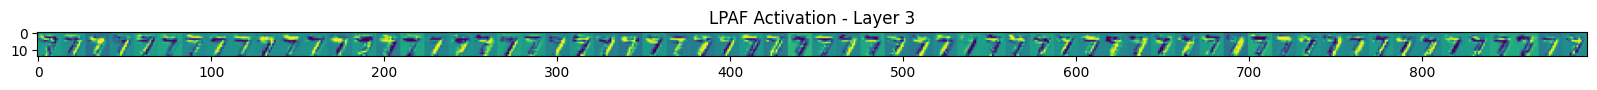

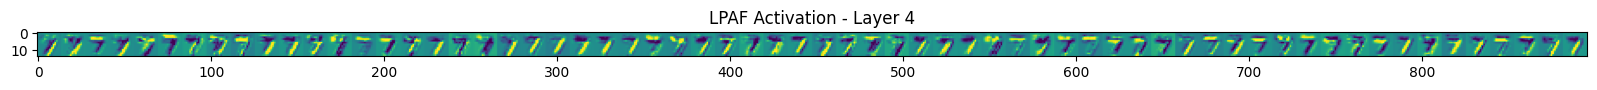

In [ ]:
# Visualize feature maps layerwise for both models
def visualize_feature_maps(model, activation_function_name):
    # Choose an image to visualize
    test_image = x_test[0]
    test_image_expanded = np.expand_dims(test_image, axis=0)
    # Get outputs of the convolutional layers
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    # Get the input tensor from the first layer
    input_img = model.layers[0].input
    # Create a model that will return the outputs given the inputs
    activation_model = Model(inputs=input_img, outputs=layer_outputs)
    activations = activation_model.predict(test_image_expanded)
    # Visualize the feature maps
    for idx, activation in enumerate(activations):
        num_filters = activation.shape[-1]
        size = activation.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= (x.std() + 1e-5)
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f'{activation_function_name} Activation - Layer {idx+1}')
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Visualize feature maps for ReLU model
print("\nVisualizing feature maps for ReLU model")
visualize_feature_maps(model_relu, "ReLU")

# Visualize feature maps for LPAF model
print("\nVisualizing feature maps for LPAF model")
visualize_feature_maps(model_lpaf, "LPAF")


# Exponential Linear Squasher Activation Function.

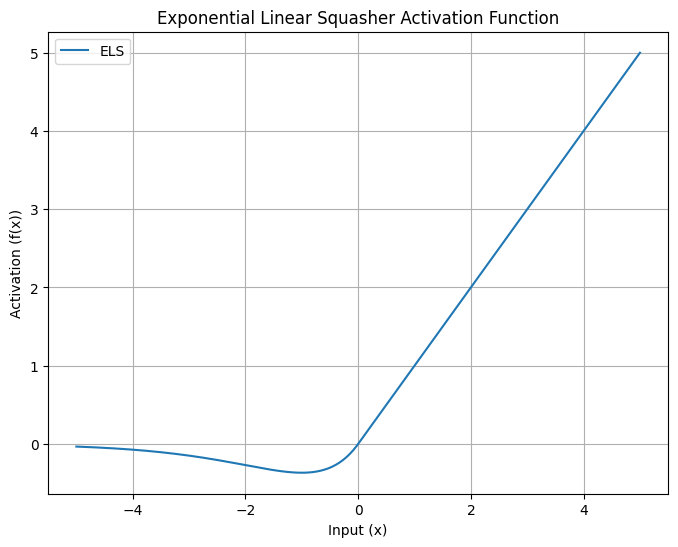

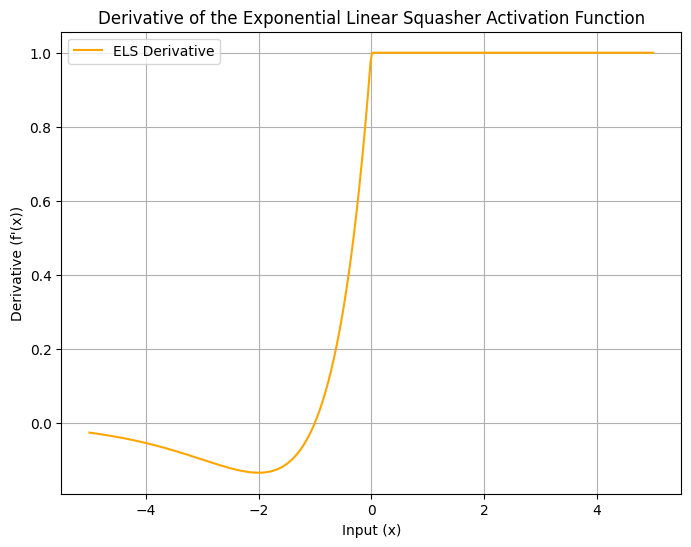

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def els(x):
    """Exponential Linear Squasher Activation Function."""
    return np.where(x >= 0, x, x * np.exp(x))

def els_derivative(x):
    """Derivative of the ELS Activation Function."""
    return np.where(x >= 0, 1, np.exp(x) * (1 + x))

# Define the range of input values
x = np.linspace(-5, 5, 400)

# Compute the activation values
y = els(x)

# Plot the activation function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='ELS')
plt.title('Exponential Linear Squasher Activation Function')
plt.xlabel('Input (x)')
plt.ylabel('Activation (f(x))')
plt.grid(True)
plt.legend()
plt.show()

# Compute the derivative values
y_derivative = els_derivative(x)

# Plot the derivative of the activation function
plt.figure(figsize=(8, 6))
plt.plot(x, y_derivative, label="ELS Derivative", color='orange')
plt.title('Derivative of the Exponential Linear Squasher Activation Function')
plt.xlabel('Input (x)')
plt.ylabel('Derivative (f\'(x))')
plt.grid(True)
plt.legend()
plt.show()



Training with ELS activation
Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9112 - loss: 0.3909Epoch 1 completed in 20.78 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9112 - loss: 0.3907 - val_accuracy: 0.9714 - val_loss: 0.1907
Epoch 2/100
933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9828 - loss: 0.1496Epoch 2 completed in 6.27 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9828 - loss: 0.1495 - val_accuracy: 0.9824 - val_loss: 0.1380
Epoch 3/100
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9882 - loss: 0.1173Epoch 3 completed in 5.73 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9882 - loss: 0.1172 - val_accuracy: 0.9894 - val_loss: 0.1011
Epoch 4/100
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9875 - loss: 0.1034Epoch 4 completed in 6.03 seconds
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9875 - loss: 0.1033 - val_accuracy: 0.9884 - val_loss: 0.0920
Epoch 5/100
933/93


Comparing Results:
Final Training Accuracy with ReLU: 0.9948166608810425
Final Validation Accuracy with ReLU: 0.9919000267982483
Final Training Accuracy with ELS: 0.9963666796684265
Final Validation Accuracy with ELS: 0.9943000078201294

Visualizing feature maps for ReLU model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


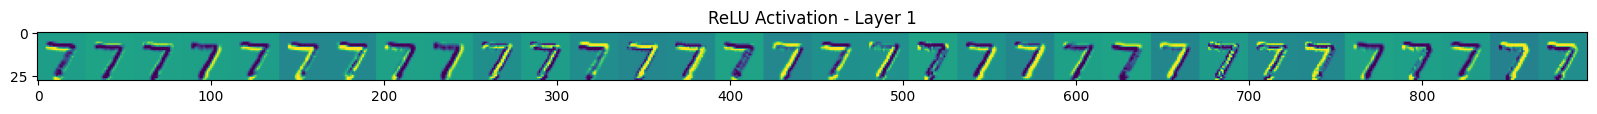

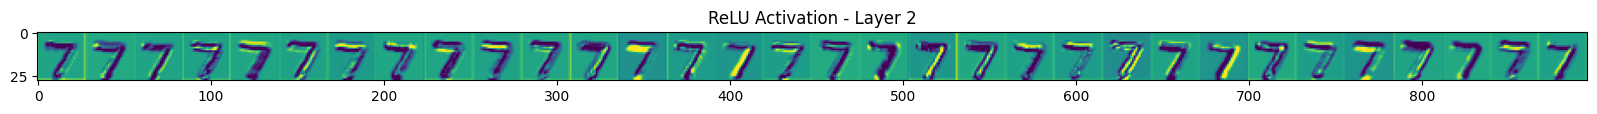

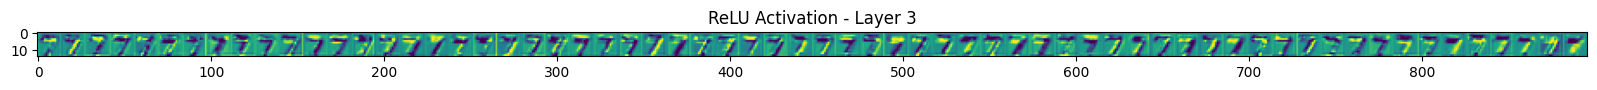

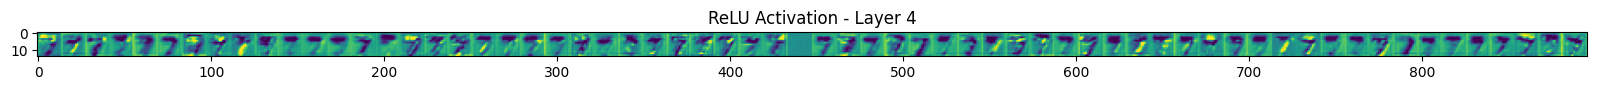


Visualizing feature maps for ELS model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


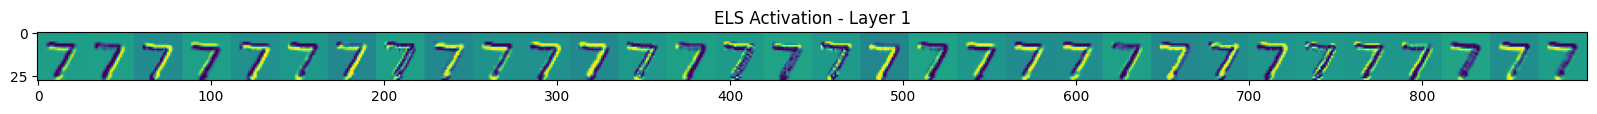

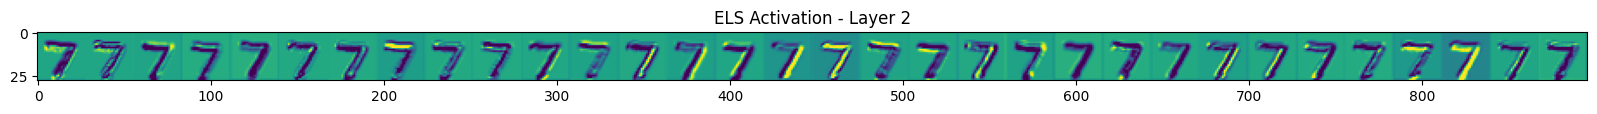

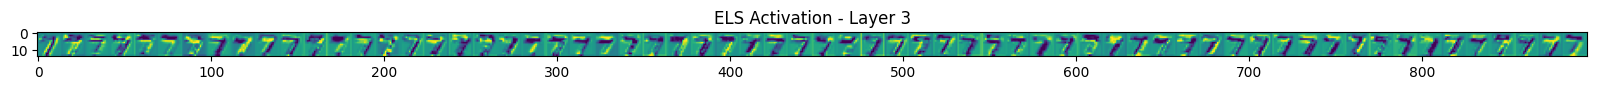

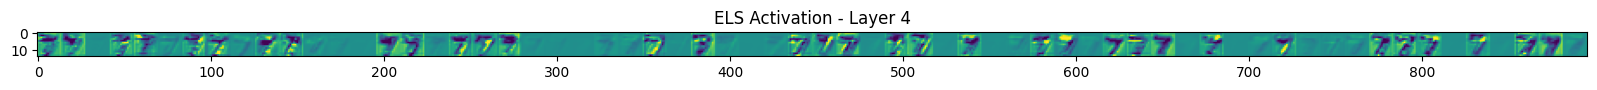

In [ ]:

# Set hyperparameters
batch_size = 64
learning_rate = 0.0005
epochs = 100
num_classes = 10

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Add channel dimension and normalize
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0    # Add channel dimension and normalize
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define Exponential Linear Squasher (ELS) Activation Function
def els(x):
    """Exponential Linear Squasher Activation Function."""
    return tf.where(x >= 0, x, x * tf.exp(x))

# Define a custom callback to measure training time per epoch
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)
        print(f"Epoch {epoch+1} completed in {self.times[-1]:.2f} seconds")

# Function to add activation layers
def add_activation(model, activation_function):
    if activation_function == 'relu':
        model.add(Activation('relu'))
    else:
        model.add(Lambda(activation_function))

# Function to build CNN model with specified activation function
def build_model(activation_function):
    weight_decay = 1e-4  # L2 regularization factor
    model = Sequential()
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(Dropout(0.2))
    # Second Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Third Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(Dropout(0.3))
    # Fourth Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training with ReLU activation
# print("Training with ReLU activation")
# model_relu = build_model('relu')
# optimizer = Adam(learning_rate=learning_rate)
# model_relu.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# time_callback = TimeHistory()
# history_relu = model_relu.fit(x_train, y_train,
#                               batch_size=batch_size,
#                               epochs=epochs,
#                               validation_data=(x_test, y_test),
#                               shuffle=True,
#                               callbacks=[time_callback, early_stopping])

# # Save the ReLU model
# model_relu.save('model_relu_mnist.h5')

# Training with ELS activation
print("\nTraining with ELS activation")
def els_activation(x):
    return els(x)

model_els = build_model(els_activation)
optimizer = Adam(learning_rate=learning_rate)
model_els.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
time_callback_els = TimeHistory()
history_els = model_els.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            shuffle=True,
                            callbacks=[time_callback_els, early_stopping])

# Save the ELS model
model_els.save('model_els_mnist.h5')

# Compare results
print("\nComparing Results:")
print("Final Training Accuracy with ReLU:", history_relu.history['accuracy'][-1])
print("Final Validation Accuracy with ReLU:", history_relu.history['val_accuracy'][-1])
print("Final Training Accuracy with ELS:", history_els.history['accuracy'][-1])
print("Final Validation Accuracy with ELS:", history_els.history['val_accuracy'][-1])

# Visualization and feature map functions remain unchanged
# Visualize feature maps for ReLU model
print("\nVisualizing feature maps for ReLU model")
visualize_feature_maps(model_relu, "ReLU")

# Visualize feature maps for LPAF model
print("\nVisualizing feature maps for ELS model")
visualize_feature_maps(model_els, "ELS")


# CIFAR-10

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training with ReLU activation
Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4009 - loss: 1.8977Epoch 1 completed in 22.60 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.4010 - loss: 1.8973 - val_accuracy: 0.4261 - val_loss: 1.9252
Epoch 2/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6127 - loss: 1.2119Epoch 2 completed in 5.86 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6128 - loss: 1.2117 - val_accuracy: 0.6257 - val_loss: 1.2244
Epoch 3/100
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6976 - loss: 0.9914Epoch 3 completed in 10.78 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6976 - loss: 0.9913 - val_accuracy: 0.6529 - val_loss: 1.1374
Epoch 4/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7304 - loss: 0.9040Epoch 4 completed in 9.90 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7304 - loss: 0.9040 - va


Training with ELS activation
Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4136 - loss: 1.8980Epoch 1 completed in 21.99 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.4137 - loss: 1.8976 - val_accuracy: 0.5879 - val_loss: 1.2797
Epoch 2/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6365 - loss: 1.1483Epoch 2 completed in 6.18 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6366 - loss: 1.1482 - val_accuracy: 0.6785 - val_loss: 1.0623
Epoch 3/100
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7057 - loss: 0.9643Epoch 3 completed in 10.28 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7057 - loss: 0.9642 - val_accuracy: 0.6328 - val_loss: 1.1913
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7448 - loss: 0.8616Epoch 4 completed in 6.26 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7448 - loss: 0.8616 - val_accuracy: 0.7395 - val_loss: 0.8804
Epoch 5/100
781/


Comparing Results:
Final Training Accuracy with ReLU: 0.9104999899864197
Final Validation Accuracy with ReLU: 0.7962999939918518
Final Training Accuracy with ELS: 0.8481199741363525
Final Validation Accuracy with ELS: 0.7883999943733215

Visualizing feature maps for ReLU model


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


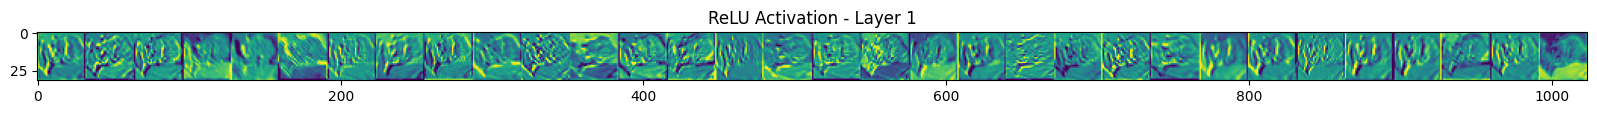

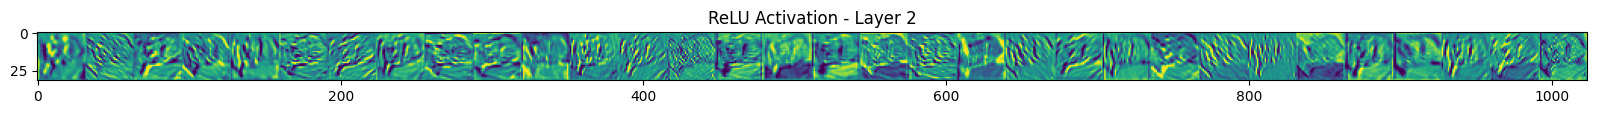

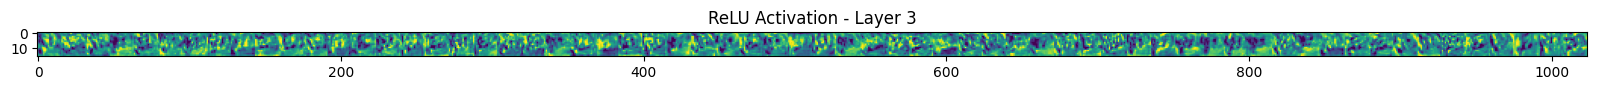

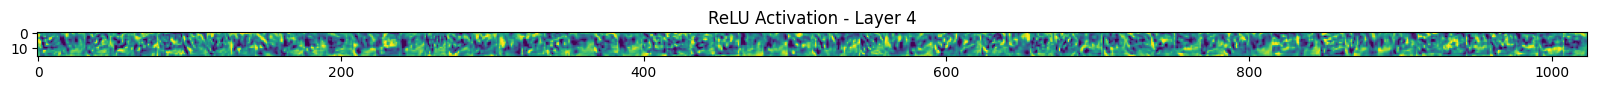


Visualizing feature maps for ELS model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


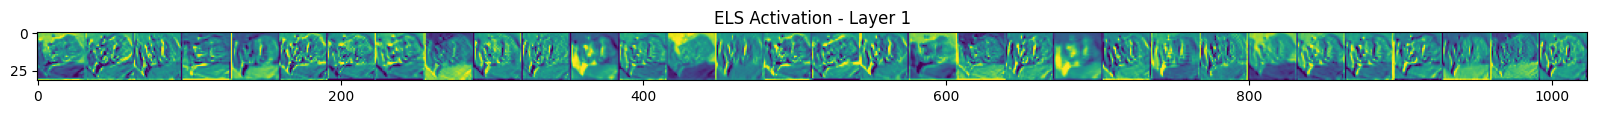

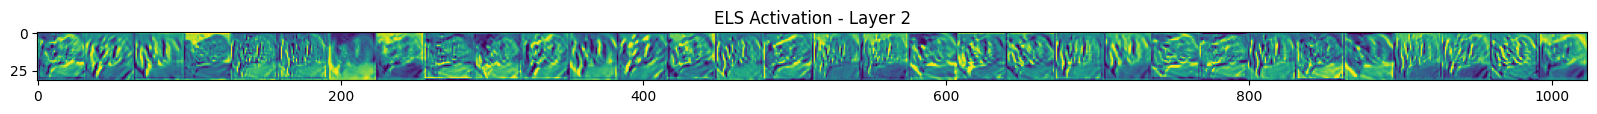

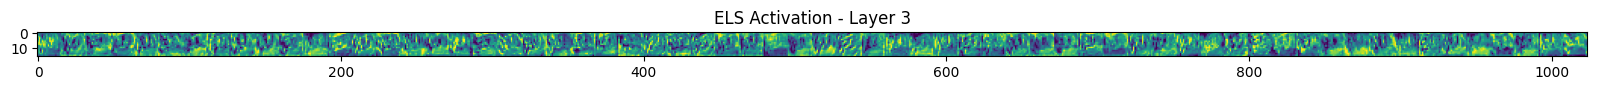

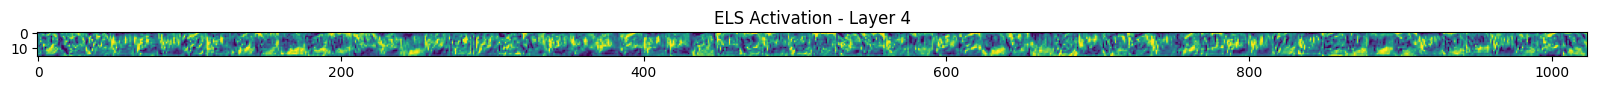

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Lambda, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import time

# Set hyperparameters
batch_size = 64
learning_rate = 0.0005
epochs = 100
num_classes = 10

# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define Exponential Linear Squasher (ELS) Activation Function
def els(x):
    """Exponential Linear Squasher Activation Function."""
    return tf.where(x >= 0, x, x * tf.exp(x))

# Define a custom callback to measure training time per epoch
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)
        print(f"Epoch {epoch+1} completed in {self.times[-1]:.2f} seconds")

# Function to add activation layers
def add_activation(model, activation_function):
    if activation_function == 'relu':
        model.add(Activation('relu'))
    else:
        model.add(Lambda(activation_function))

# Function to build CNN model with specified activation function
def build_model(activation_function):
    weight_decay = 1e-4  # L2 regularization factor
    model = Sequential()
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(Dropout(0.2))
    # Second Convolutional Block
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Third Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(Dropout(0.3))
    # Fourth Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, activation_function)
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training with ReLU activation
print("Training with ReLU activation")
model_relu = build_model('relu')
optimizer = Adam(learning_rate=learning_rate)
model_relu.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
time_callback = TimeHistory()
history_relu = model_relu.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(x_test, y_test),
                              shuffle=True,
                              callbacks=[time_callback, early_stopping])

# Save the ReLU model
model_relu.save('model_relu_cifar10.h5')

# Training with ELS activation
print("\nTraining with ELS activation")
def els_activation(x):
    return els(x)

model_els = build_model(els_activation)
optimizer = Adam(learning_rate=learning_rate)
model_els.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
time_callback_els = TimeHistory()
history_els = model_els.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            shuffle=True,
                            callbacks=[time_callback_els, early_stopping])

# Save the ELS model
model_els.save('model_els_cifar10.h5')

# Compare results
print("\nComparing Results:")
print("Final Training Accuracy with ReLU:", history_relu.history['accuracy'][-1])
print("Final Validation Accuracy with ReLU:", history_relu.history['val_accuracy'][-1])
print("Final Training Accuracy with ELS:", history_els.history['accuracy'][-1])
print("Final Validation Accuracy with ELS:", history_els.history['val_accuracy'][-1])


# Visualize feature maps for ReLU model
print("\nVisualizing feature maps for ReLU model")
visualize_feature_maps(model_relu, "ReLU")

# Visualize feature maps for ELS model
print("\nVisualizing feature maps for ELS model")
visualize_feature_maps(model_els, "ELS")

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Define ELS activation function
def els(x):
    """Exponential Linear Squasher Activation Function."""
    return tf.where(x >= 0, x, x * tf.exp(x))

# Function to add activation layers
def add_activation(model, activation_function):
    model.add(Lambda(activation_function))

# Build model with optimized architecture for ELS
def build_optimized_model():
    weight_decay = 5e-4  # Increased L2 regularization to prevent overfitting
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(Dropout(0.3))  # Increased dropout rate

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))  # Increased depth
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(Dropout(0.4))  # Increased dropout rate

    # Fourth Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, kernel_regularizer=l2(weight_decay)))  # Reduced FC layer size for better regularization
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes
    return model

# Compile and train the model
def train_model(model, learning_rate=0.0005, batch_size=64, epochs=100):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        shuffle=True,
                        callbacks=[early_stopping])
    return history

# Build and train the optimized ELS model
print("Training Optimized ELS Model on CIFAR-10...")
optimized_els_model = build_optimized_model()
history_optimized_els = train_model(optimized_els_model)

# Evaluate the optimized model
final_train_acc = history_optimized_els.history['accuracy'][-1]
final_val_acc = history_optimized_els.history['val_accuracy'][-1]
print("\nFinal Training Accuracy with Optimized ELS:", final_train_acc)
print("Final Validation Accuracy with Optimized ELS:", final_val_acc)


Training Optimized ELS Model on CIFAR-10...
Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.3641 - loss: 2.3240 - val_accuracy: 0.5171 - val_loss: 1.8259
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.5752 - loss: 1.5914 - val_accuracy: 0.6782 - val_loss: 1.2952
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6662 - loss: 1.3179 - val_accuracy: 0.7257 - val_loss: 1.1384
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7032 - loss: 1.1844 - val_accuracy: 0.7174 - val_loss: 1.1351
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7252 - loss: 1.1098 - val_accuracy: 0.7211 - val_loss: 1.1433
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7381 - loss: 1.0655 - val_accuracy: 0.7592 - val_loss: 1.0174
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7621 - loss: 1.0197 - val_accuracy: 0.7605 - val_loss: 1.0193
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Define ELS activation function
def els(x):
    """Exponential Linear Squasher Activation Function."""
    return tf.where(x >= 0, x, x * tf.exp(x))

# Function to add activation layers
def add_activation(model, activation_function):
    model.add(Lambda(activation_function))

# Build optimized model with ELS activation
def build_optimized_model():
    weight_decay = 5e-4  # L2 regularization factor
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(Dropout(0.3))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(Dropout(0.4))

    # Fourth Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    add_activation(model, els)
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))
    return model

# Compile and train the model
def train_model_with_augmentation(model, learning_rate=0.0005, batch_size=64, epochs=100):
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    datagen.fit(x_train)

    # Optimizer and callbacks
    optimizer = Adam(learning_rate=learning_rate)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train) // batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping, lr_scheduler]
    )
    return history

# Build and train the optimized ELS model
print("Training Optimized ELS Model on CIFAR-10...")
optimized_els_model = build_optimized_model()
history_optimized_els = train_model_with_augmentation(optimized_els_model)

# Evaluate the optimized model
final_train_acc = history_optimized_els.history['accuracy'][-1]
final_val_acc = history_optimized_els.history['val_accuracy'][-1]
print("\nFinal Training Accuracy with Optimized ELS:", final_train_acc)
print("Final Validation Accuracy with Optimized ELS:", final_val_acc)


Training Optimized ELS Model on CIFAR-10...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 55s 57ms/step - accuracy: 0.3228 - loss: 2.4306 - val_accuracy: 0.5514 - val_loss: 1.6575 - learning_rate: 5.0000e-04
Epoch 2/100
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4375 - loss: 2.0743

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4375 - loss: 2.0743 - val_accuracy: 0.5531 - val_loss: 1.6484 - learning_rate: 5.0000e-04
Epoch 3/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.5045 - loss: 1.7687 - val_accuracy: 0.6336 - val_loss: 1.3922 - learning_rate: 5.0000e-04
Epoch 4/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5000 - loss: 1.6470 - val_accuracy: 0.6285 - val_loss: 1.4054 - learning_rate: 5.0000e-04
Epoch 5/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.5876 - loss: 1.5092 - val_accuracy: 0.6940 - val_loss: 1.1977 - learning_rate: 5.0000e-04
Epoch 6/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5781 - loss: 1.4438 - val_accuracy: 0.6930 - val_loss: 1.2011 - learning_rate: 5.0000e-04
Epoch 7/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.6333 - loss: 1.3614 - val_accuracy: 0.7061 - val_loss: 1.1609 - learning_rate: 5.0000e-04
Epoch 8/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy:

# RESNET-50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define ELS activation function
def els(x):
    return tf.where(x >= 0, x, x * tf.math.exp(x))

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
y_train, y_test = tf.keras.utils.to_categorical(y_train, 10), tf.keras.utils.to_categorical(y_test, 10)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(x_train)

# Load pretrained ResNet50 model
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=Input(shape=(32, 32, 3)))

# Freeze all layers in the base model
base_model.trainable = False

# Add custom layers with ELS activation
x = Flatten()(base_model.output)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Lambda(els)(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Lambda(els)(x)
x = Dropout(0.5)(x)
output = Dense(10, activation="softmax")(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=100,
    callbacks=[lr_scheduler],
    verbose=1
)

# Evaluate the model
final_train_acc = model.evaluate(x_train, y_train, verbose=0)[1]
final_val_acc = model.evaluate(x_test, y_test, verbose=0)[1]
print(f"Final Training Accuracy with Optimized ELS (ResNet-50): {final_train_acc}")
print(f"Final Validation Accuracy with Optimized ELS (ResNet-50): {final_val_acc}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.2614 - loss: 2.1877 - val_accuracy: 0.1966 - val_loss: 2.4663 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 47ms/step - accuracy: 0.3561 - loss: 1.7833 - val_accuracy: 0.1239 - val_loss: 3.4329 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.3815 - loss: 1.7182 - val_accuracy: 0.2928 - val_loss: 2.2011 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.3976 - loss: 1.6924 - val_accuracy: 0.1750 - val_loss: 3.0763 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.4115 - loss: 1.6580 - val_accuracy: 0.2513 - val_loss: 2.1979 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.4156 - loss: 1.6433 - val_accuracy: 0.2369 - val_loss: 2.5937 - learning_rate: 0.0010
Epoch 7/100
782/782